# Ejercicio preedicción alquiler de biciceltas
Una empresa de bicicletas compartidas que opera en el área de una ciudad específica tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar bicicletas desde un lugar en particular y devolverla en un lugar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro. En el csv aparecen el número de bicicletas contratadas todos los días y las variables meteorológica de esos días.

Se usará __análisis de regresión__ con el fin de capturar la relación entre las características y el número de bicicletas contratadas en un modelo.



## author: Virginia Ordoño Bernier
## date:January 2024

### Carga de datos

In [47]:
import pandas as pd

csv = 'data/bikes.csv'
data = pd.read_csv(csv)
df_bikes = pd.DataFrame(data)
df_bikes = df_bikes.set_index('date') # date as index
print(df_bikes.head())

            temperature   humidity  windspeed  count
date                                                
2011-01-03     2.716070  45.715346  21.414957  120.0
2011-01-04     2.896673  54.267219  15.136882  108.0
2011-01-05     4.235654  45.697702  17.034578   82.0
2011-01-06     3.112643  50.237349  10.091568   88.0
2011-01-07     2.723918  49.144928  15.738204  148.0


### Preparación de los datos para el entrenamiento

In [48]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_bikes, test_size=0.2, random_state=42)

# Reset index to maintain original order
test = test.sort_index()
train = train.sort_index()

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
            temperature   humidity  windspeed       count
date                                                     
2011-01-03     2.716070  45.715346  21.414957  120.000000
2011-01-04     2.896673  54.267219  15.136882  108.000000
2011-01-06     3.112643  50.237349  10.091568   88.000000
2011-01-07     2.723918  49.144928  15.738204  148.000000
2011-01-08     1.967445  48.851252  17.035029  112.333333

Conjunto de prueba:
            temperature   humidity  windspeed  count
date                                                
2011-01-05     4.235654  45.697702  17.034578   82.0
2011-01-13     1.158189  47.565957  25.173470   38.0
2011-01-26     3.765915  69.458098  24.663452   34.0
2011-02-02     5.876931  64.595777  22.556185   72.0
2011-02-03     2.248815  45.746223  23.515162   61.0


c:\Users\vober\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


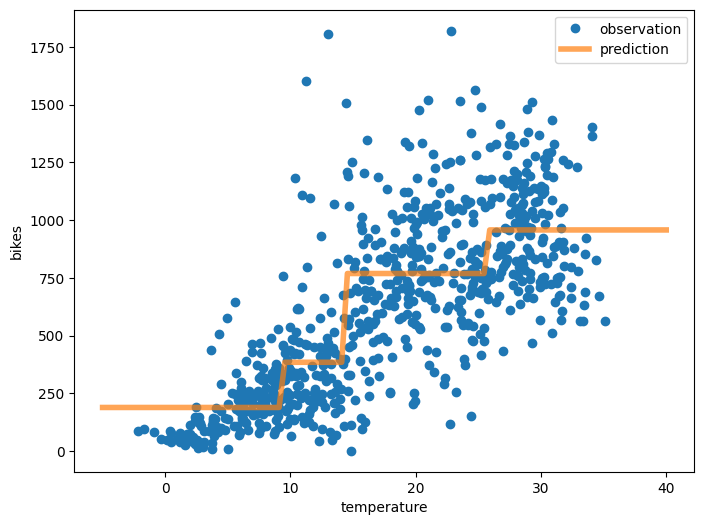

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=2, random_state=0)
regressor.fit(df_bikes[['temperature']], df_bikes['count'])
xx = np.linspace(-5, 40, 100) # 100 values between -5 and 40

plt.figure(figsize=(8,6))
plt.plot(df_bikes['temperature'], df_bikes['count'], 'o', label='observation')
# Reshape transform a one dimension list to 2 dimensions. reshape(-1=don´t know rows amount, 1 = one column)
# alpha = transparency
plt.plot(xx, regressor.predict(xx.reshape(-1,1)), linewidth=4, alpha=.7, label='prediction')
plt.xlabel('temperature')
plt.ylabel('bikes')
plt.legend()
plt.show()

### Implementación del árbol de decisión

In [50]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Selecting regressor. criterion = 'squared_error', is by default
regressor = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 2)

# Training (input data and output data)
regressor.fit(train[['temperature']], train['count'])

# Prediction 
y_pred = regressor.predict(test[['temperature']])

# Evaluation
mae = mean_absolute_error(test['count'], y_pred)

print(f'Error absoluto medio: {round(mae, 2)}')

Error absoluto medio: 178.43


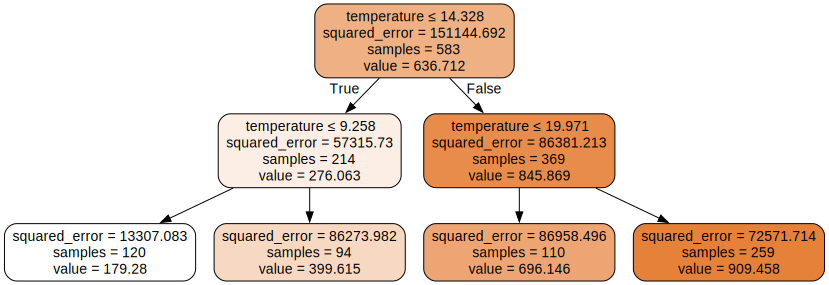

In [53]:
import graphviz
from sklearn.tree import export_graphviz

# Crear un archivo DOT que representa el árbol de decisión (en este caso se devuelve como cadena)
dot_data = export_graphviz(regressor, out_file=None, feature_names=["temperature"], filled=True, rounded=True, special_characters=True)

# Generar el gráfico del árbol de decisión desde el archivo DOT
graph = graphviz.Source(dot_data)

# Mostrar el gráfico en Jupyter Notebook o en un archivo
#graph.view("arbol_de_decision")  # Esto guardará el gráfico en un archivo llamado "arbol_de_decision.pdf"
display(graph)

In [54]:
### Caraterísticas relevantes
X_train = train.drop('count', axis=1)
y_train = train['count']

# Gini criterio by default
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Get importance
importances = regressor.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Exclude column 'index' if exists
if 'index' in feature_importance_df['Feature'].values:
    feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia de las Variables:")
print(feature_importance_df)


Informe de Importancia de las Variables:
       Feature  Importance
0  temperature    0.675184
1     humidity    0.195627
2    windspeed    0.129189


### Validación cruzada

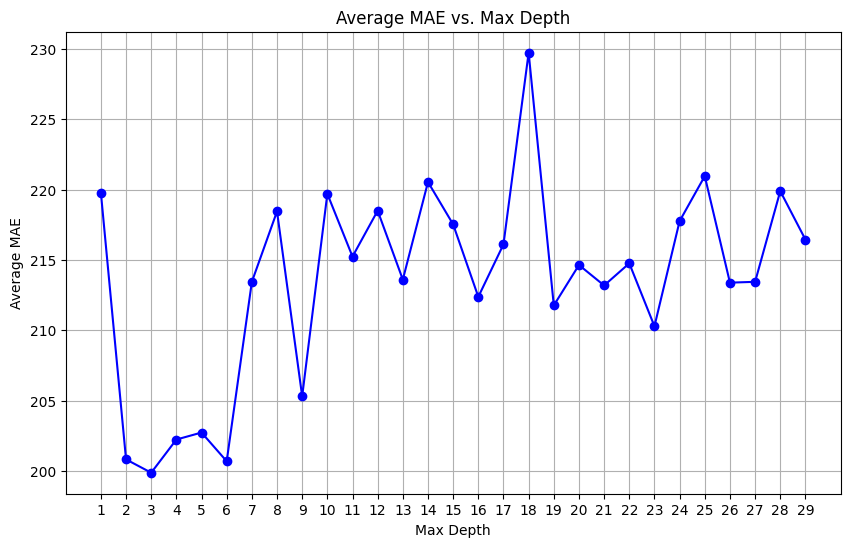

Best Max Depth: 3
Corresponding Minimum Average MAE: 199.87029561313017


In [55]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Column 'date' converted to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# Select more important features
df_cv = data[['temperature', 'humidity', 'count']]

# Filter by date
train = df_cv.loc['2011-01-01':'2012-06-30']
test = df_cv.loc['2012-07-01':]

cv = TimeSeriesSplit(n_splits=4)

total_scores = []

# Trying with different depths
best_depth = None
min_mae = float('inf')

for i in range(1, 30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    
    for train_fold, test_fold in cv.split(train):
        # Divide train and test groups
        f_train = train.iloc[train_fold]
        f_test = train.iloc[test_fold]
        
        # Train the model on the current fold
        dt.fit(
            X = f_train.drop(['count'], axis = 1),
            y = f_train['count']
        )
        X_test = f_test.drop(['count'], axis = 1)
        y_pred = dt.predict(X_test)
        
        # Evaluation
        mae = mean_absolute_error(f_test['count'], y_pred)
        fold_accuracy.append(mae)
    
    # Calculate and store the average accuracy for the current depth
    avg_mae = np.mean(fold_accuracy)
    total_scores.append(avg_mae)

    # Check if the current depth results in a lower MAE
    if avg_mae < min_mae:
        min_mae = avg_mae
        best_depth = i

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), total_scores, marker='o', linestyle='-', color='b')
plt.title('Average MAE vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Average MAE')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()

# Print the results
print(f"Best Max Depth: {best_depth}")
print(f"Corresponding Minimum Average MAE: {min_mae}")

### Ejecutar el mdoelo con el dato actualizada con el mejor parámetro: la profundidad que da menor error, en este caso profundidad 5

In [56]:
# Selecting regressor. Mean Squared Error by default
regressor = DecisionTreeRegressor(max_depth = 5)

# Training with all the group
regressor.fit(
    X = train.drop(['count'], axis = 1),
    y = train['count']
)

# Prediction 
y_pred = regressor.predict( X = test.drop(['count'], axis = 1))

# Evaluation
mae = mean_absolute_error(test['count'], y_pred)

print(f'Error absoluto medio: {round(mae, 2)}')

Error absoluto medio: 254.34


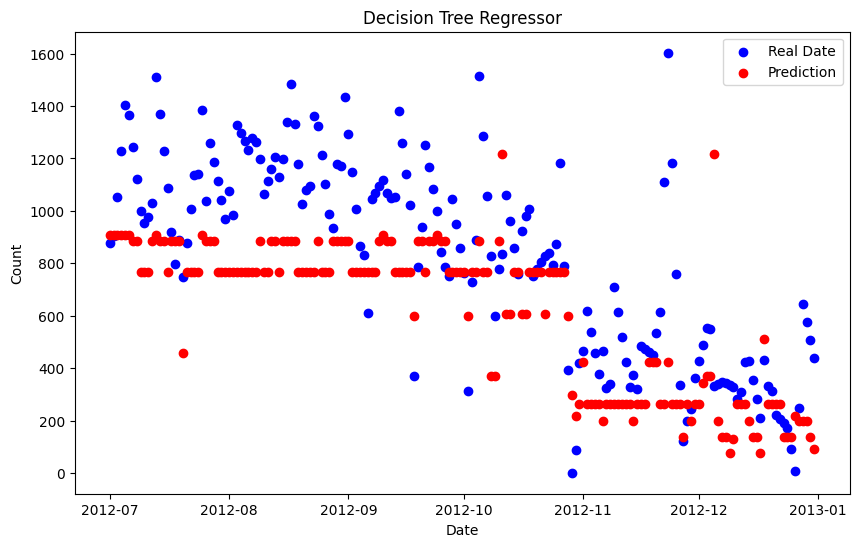

In [57]:
import matplotlib.pyplot as plt

# ... (código anterior)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['count'], label='Real Date', color='blue')
plt.scatter(test.index, y_pred, label='Prediction', color='red')
plt.title('Decision Tree Regressor')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()
